# Загрузка библиотек

Если какие-то из библиотек не установлены - используйте !pip install

Для работы на Kaggle требуется верифицированный по номеру телефона профиль (без него не сработает pip install (точнее, нельзя будет в настройках включить работу с интернетом) и не подключить графические ускорители). Если при попытке верификации по номеру выдает ошибку "this phone number can't be verified" - попробуйте обратиться в техподдержку Kaggle, они ответят в течении 1-2 дней и уберут ошибку при вводе того же номера (личный опыт).

На удаленных средах (Kaggle, Google Colab), для работы с данными/модификации преобразований изображений, графические ускорители можно не подключать, и работать в стандартной среде. В противном случае - перед запуском кода подлючите графические ускорители (в Kaggle: Session Options -> Accelerator -> GPU T4 x 2, в Google Colab - меню рядом со статусом ОЗУ/Диск -> Сменить среду выполнения -> Графический ускоритель T4).

In [2]:
import numpy as np
import pandas as pd

import random
import glob
import os, shutil
from tqdm import tqdm
tqdm.pandas()
import time
import copy
import joblib
from collections import defaultdict
import gc
from IPython import display as ipd

# visualization
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Sklearn
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold
from sklearn.model_selection import train_test_split

# PyTorch 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp

import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

from joblib import Parallel, delayed

# For colored terminal text
from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import sys
import h5py
from sklearn.preprocessing import StandardScaler

#Модели машинного обучения
import segmentation_models_pytorch as smp

#Утилиты для работы с GPU
import GPUtil

# Загрузка данных

Перед работой с данными, их нужно загрузить на компьютер/удаленную среду.

Для загрузки на компьютер, используйте скрипт для загрузки (находится в другом jupyter notebook).

Для загрузки на Google Colab с компьютера ни в коем случае не используйте внутрисессионное хранилище - данные пропадут при смене среды (а грузится они будут очень долго), загрузите данные на Google Drive в архиве .zip (во первых так данные будут меньше, а во вторых процедура "загрузка .zip с Google Drive в Google Colab -> распаковка .zip в Google Colab" быстрее процедуры "загрузи все несжатые данные с Google Drive", в третьих в стандартный бесплатный объем Google Drive несжатые данные не влезут).

Для загрузки на Kaggle с компьютера испольйте в меню справа Input -> Upload.

В данной реализации сегментации, используются только Cor снимки, поэтому, при желании, можно не загружать другие типы снимков (это существенно уменьшит вес загружаеммых данных).

In [7]:
#Преобразует tif файлы в массив масок и снимков
def load_tif(x_path, y_path,count_dict, step=4):
    images = []
    masks = []
    mean = []
    image = Image.open(x_path)
    mask = Image.open(y_path)
    i = 0
    cnt = 0    

    while True:
        try:
            mask.seek(i)
            mask_array = np.array(mask)
            image.seek(i)
            image_array = np.array(image)
            mean.append(sum(sum(mask_array)))
            if sum(sum(mask_array)) > 0: #Проверка, что маска не полностью черная
                    masks.append(mask_array)
                    images.append(image_array)
            cnt+=1                    

            i += 1
        except EOFError:
            break

    if 'T1' in x_path:
        count_dict['scan'].append('T1')
    elif 'T2' in x_path:
        count_dict['scan'].append('T2')     
    count_dict['count'].append(cnt) 

    return images, masks

In [9]:
#Достаем изображения и маски из многослойного tif файла
def get_images(x_pathes, y_pathes):

    images =[]
    masks = []
    count_dict = {'scan':[],'count':[],}
    for x_path, y_path in zip(x_pathes, y_pathes):
          
          images_sample,mask_sample = load_tif(x_path, y_path,count_dict)
          for im,ms in zip(images_sample,mask_sample):
                
                images.append(im)
                masks.append(ms)
              
    print(len(count_dict['count']))
    return images, masks ,count_dict

In [11]:
#Обходит директорию и сохранятет пути пациентов, вычленяет проекции Cor T1 и Cor T2 и маски
def get_pathes(path): 
    x_pathes_all = []
    y_pathes_all = []
    for patient in os.listdir(path):
        x_pathes = []
        y_pathes = []
      
        for ID_s in os.listdir(path + '/'+ patient ):
            if 'ID' in ID_s:
                msk_t1 = 0
                msk_t2 = 0  
                for tif_name in os.listdir(path + '/'+ patient + '/'+ID_s):
    
                    if 'Cor' in tif_name:
                        if 'T1' in tif_name:
            
                            if  'mask' not in tif_name.lower():
                                x_pathes.append(path + '/'+ patient + '/' + ID_s + '/'+ tif_name)

                            elif 'mask' in tif_name.lower():
                                msk_t1 = 1
                                y_pathes.append(path + '/'+ patient + '/'+ID_s + '/' + tif_name)

                        elif 'T2' in tif_name:
                            
                            if 'mask' not in tif_name.lower():
                                x_pathes.append(path + '/'+ patient + '/'+ID_s + '/' + tif_name)
                              
                            elif 'mask' in tif_name.lower():
                                msk_t2 = 1
                                y_pathes.append(path + '/'+ patient + '/'+ID_s + '/' + tif_name)
                        
                if msk_t1==0:
                    x_pathes.pop()
                if msk_t2==0:
                    x_pathes.pop()
                        
        x_pathes_all.append(x_pathes)
        y_pathes_all.append(y_pathes)
                                
    return x_pathes_all, y_pathes_all

In [13]:
def flatten(xss): # для развертки и однородности списков 

    return [x for xs in xss for x in xs]

Указываем путь, где хранится папка с данными. Для корректной работы, данные должны быть в таком же формате, как формирует скрипт для скачки данных. Данный формат представляет собой папку, где данные каждого пациента хранятся в папках "ID_{номер_пациента}", в каждой такой папке хранится папка "ID {номер пациента}" с .tif изображениями, а также файл labels.txt с категориями Knosp. В текущей реализации сегментации, файлы labels.txt, а также все не коронарные снимки (без Cor в названии) не используются, поэтому, при работе с удаленной средой (Kaggle/Google colab) их можно не загружать (это в несколько раз уменьшит вес загружаемого файла с данными)

In [16]:
#Указываем путь до папки с данными. Формат данных - как формирует скрипт загрузки датасета

#Примеры пути для разных сред

#При хранении на Google Drive при работе с Google Colab (в данном примере - данные не сжаты в .zip архиве)
#from google.colab import drive
#drive.mount('/content/drive')
#x_pth, y_pth = get_pathes('/content/drive/MyDrive/data_pituitary_test_light')

#Формат ссылки при хранении на Kaggle
# x_pth, y_pth = get_pathes('/kaggle/input/med-test-light/data_pituitary_test_light')

#Формат ссылки, при хранении на локальном компьютере
x_pth, y_pth = get_pathes('C:/Users/12345654321/data_pituitary_18_01_25')

In [18]:
#Разбиваем данные на train и validation, при желании можно поменять test_size.

x_pth_train,x_pth_val,y_pth_train,y_pth_val = train_test_split(x_pth , y_pth, test_size=0.14)

x_pth_train,y_pth_train,x_pth_val,y_pth_val = flatten(x_pth_train) ,flatten(y_pth_train),flatten(x_pth_val),flatten(y_pth_val)

In [20]:
#Достает изображения и маски, преобразуя в массивы. 

#Первая цифра output - кол-во tif файлов в test датасете (по 2 файла (Cor T1 и Cor T2) на пациента, не включая маски)
#Вторая цифра output - кол-во tif файлов в train датасете (по 2 файла (Cor T1 и Cor T2) на пациента, не включая маски)

x_val,y_val,_ = get_images(x_pth_val ,y_pth_val) 

x_train,y_train,_= get_images(x_pth_train ,y_pth_train)

86
514


# Преобразование данных

In [22]:
class BuildDataset(torch.utils.data.Dataset): # загружает в оперативную память
    
    def __init__(self, X,y, label=True, transforms=None):
        self.label      = label
        self.img_paths  = X
        self.msk_paths  = y
        self.transforms = transforms
        
    def __len__(self):

        return len(self.img_paths)
    
    def __getitem__(self, index):

        if self.label == True:

            img = self.img_paths[index]
            msk = self.msk_paths[index]

            if self.transforms:

                data = self.transforms(image=np.array(img/255., dtype=np.float32)  , mask=np.array(msk, dtype=np.float32))
                img  = data['image']
                msk  = data['mask']

            return torch.tensor([img]), torch.tensor([msk])

        else:

            img = self.img_paths[index]
            if self.transforms:
                data = self.transforms(image=np.array(img/255., dtype=np.float32))
                img  = data['image']
            return torch.tensor([img])

Здесь происходит преобразование данных с изображений (их обрезка, нормализация итд). Можно попробовать поизменять тут параметры для улучшения качества обучения. Будьте внимательны - не все преобразования можно не дублировать в valid. Повороты/dropout части картинки для улучшения качества обучения - норм, существенная обрезка изображения/изменение яркостей пикселей - не норм, дублируйте в valid.

In [24]:
data_transforms = {
    "train": A.Compose([
        A.augmentations.crops.transforms.CenterCrop(256,256),
        A.Resize(256,256, interpolation=cv2.INTER_NEAREST),
        A.CoarseDropout(max_holes=8, max_height=256//20, max_width=256//20,
                         min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
        

        A.HorizontalFlip(p=0.5),
#         A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
        A.OneOf([
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
            # A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
        ], p=0.25),
        # A.ColorJitter(brightness=0, contrast=0.0002, saturation=0, hue=0.2, always_apply=False, p=0.5),
        # A.CoarseDropout(max_holes=8, max_height=224//20, max_width=224//20,
        #                  min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
        A.augmentations.Normalize(mean=(0.485, ), std=(0.229, )),
        ], p=1.0),
    
    "valid": A.Compose([
        A.augmentations.crops.transforms.CenterCrop(256,256),
        A.Resize(256,256, interpolation=cv2.INTER_NEAREST),
        A.augmentations.Normalize(mean=(0.485, ), std=(0.229, )),
        ], p=1.0)
}

Подготовка данных для загрузки в модель. Здесь можно поменять batch_size, это может повлиять на обучение.

In [26]:
train_dataset = BuildDataset(x_train,y_train, transforms=data_transforms['train'])
valid_dataset = BuildDataset(x_val,y_val, transforms=data_transforms['valid'])

train_loader = DataLoader(train_dataset, batch_size=32,shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

Здесь происходит визуализация преобразованных данных. Используйте чтобы примерно оценить, что произошло с данными после преобразования/найти ошибки в коде.

In [28]:
def plot_batch(imgs, msks, size=3):
    plt.figure(figsize=(5*5, 5))
    for idx in range(size):
        plt.subplot(1, size, idx+1)
        img = imgs[idx,].permute((1, 2, 0)).numpy()*255.0 
        msk = msks[idx,].permute((1, 2, 0)).numpy()
        show_img(img, msk)
    plt.tight_layout()
    plt.show()

In [30]:
def show_img(img, mask=None):

    plt.imshow(img, cmap='bone')        

    plt.imshow(mask, alpha=0.5)
    handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0)]]
    labels = ["Adenoma"]
    plt.legend(handles,labels)
    plt.axis('off')

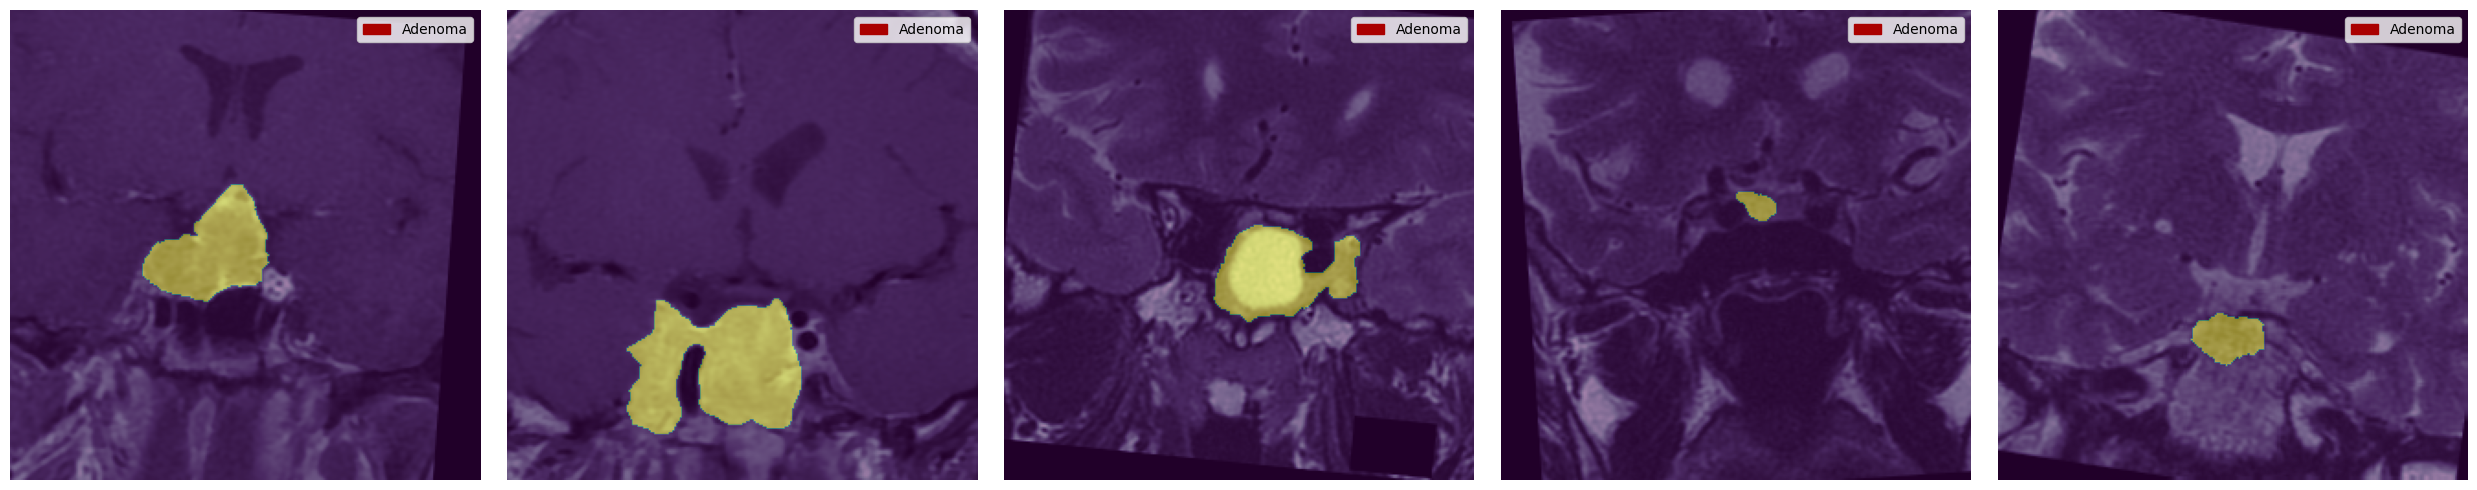

In [34]:
#Изображение после train преобразования + маска.

imgs, msks = next(iter(train_loader))
imgs.size(), msks.size()
plot_batch(imgs, msks, size=5)

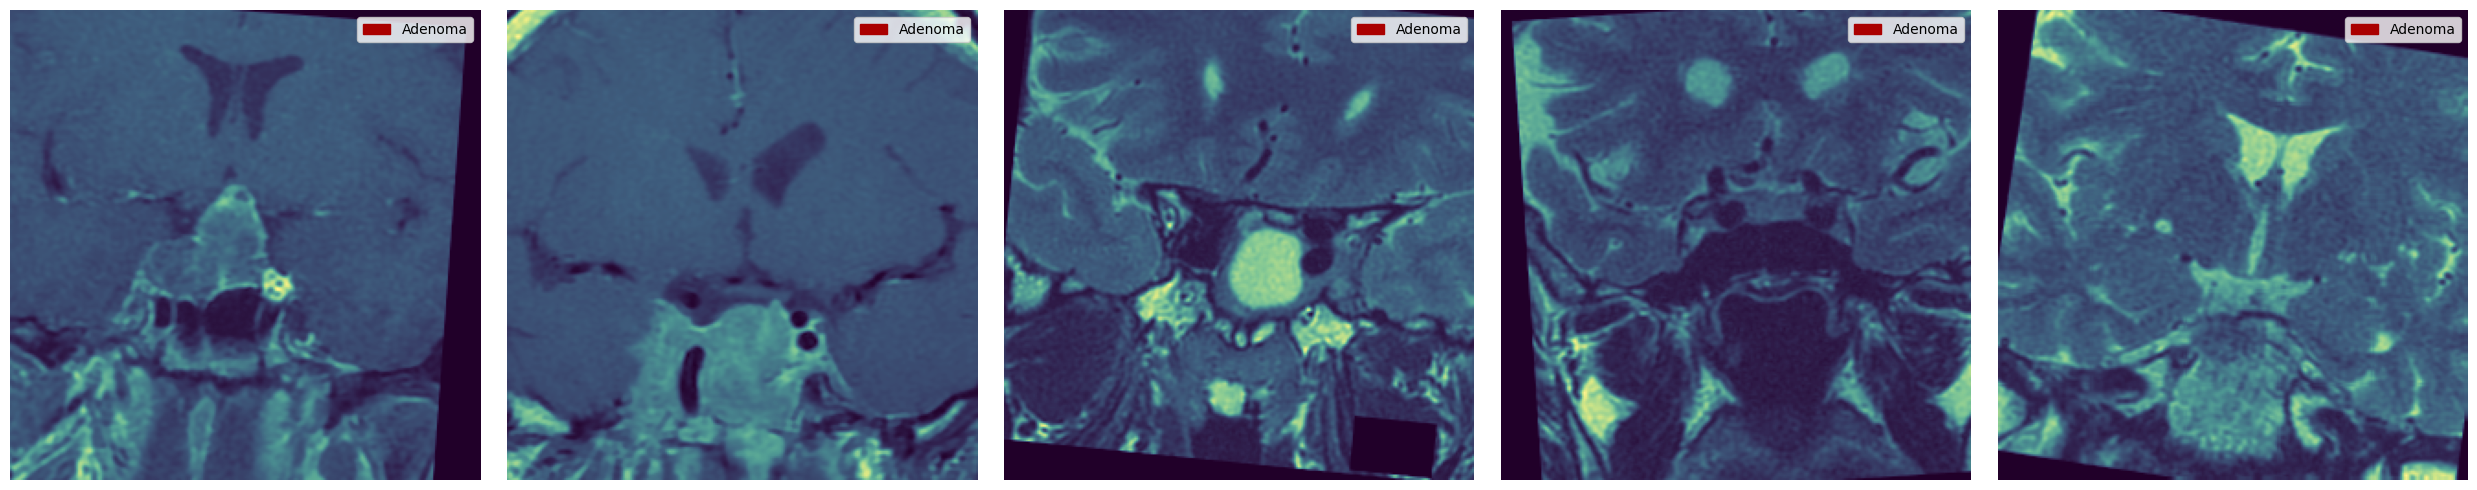

In [36]:
#Изображение после train преобразования

plot_batch(imgs, imgs, size=5)

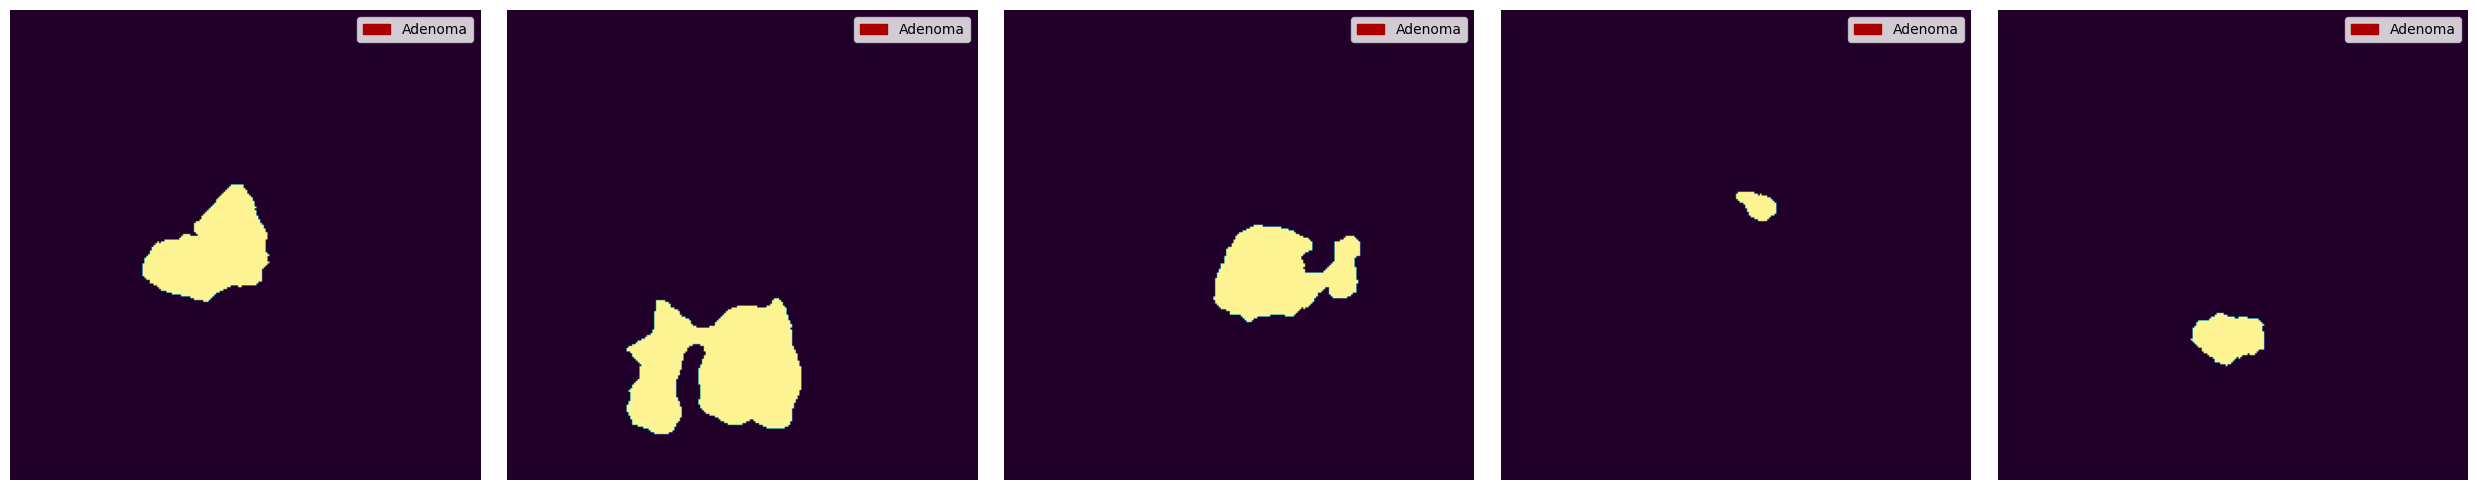

In [38]:
#Маска

plot_batch(msks, msks, size=5)

# Модель

In [40]:
#Принудительно включаем garbage collector (чтобы улучшить производительность обучения)

gc.collect()

9760

Архитектура модели. Используются реализации из библиотеки segmentation_models_pytorch. Саму модель/ее параметры (encoder_name) можно поменять.

In [44]:
def build_model():
    model = smp.UnetPlusPlus(
        encoder_name='efficientnet-b6' ,
                  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights='imagenet',# use `imagenet` pre-trained weights for encoder initialization
        in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=1   ,     # model output channels (number of classes in your dataset)
        activation=None,
    )
    model.to('cuda')
    return model

def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

# Loss

Здесь настраивается Loss (функция criterion), также есть фунции ручного расчета dice_coef и iou_coef.

In [46]:
JaccardLoss = smp.losses.JaccardLoss(mode='binary')
DiceLoss    = smp.losses.DiceLoss(mode='binary')
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()
LovaszLoss  = smp.losses.LovaszLoss(mode='binary', per_image=False)
TverskyLoss = smp.losses.TverskyLoss(mode='binary', log_loss=False)

def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

def criterion(y_pred, y_true):
    return BCELoss(y_pred, y_true) + TverskyLoss(y_pred, y_true)

# Обучение

In [55]:
#Обучение одной эпохи

def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    scaler = amp.GradScaler()
    train_scores = []
    dataset_size = 0
    running_loss = 0.0
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
    for step, (images, masks) in pbar:         
        images = images.to(device, dtype=torch.float)
        masks  = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        with amp.autocast(enabled=True):
            y_pred = model(images)
            
            loss   = criterion(y_pred, masks)
            loss   = loss / CFG.n_accumulate
            
        scaler.scale(loss).backward()
    
        if (step + 1) % CFG.n_accumulate == 0:
            scaler.step(optimizer)
            scaler.update()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size

        y_pred = (nn.Sigmoid()(y_pred)).double()
        train_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
        vtrain_jaccard = iou_coef(masks, y_pred).cpu().detach().numpy()
        train_scores.append([train_dice, vtrain_jaccard])
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_mem=f'{mem:0.2f} GB')
        
    train_scores  = np.mean(train_scores, axis=0)    
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss,train_scores

In [57]:
#Валидация одной эпохи

@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    val_scores = []
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
    for step, (images, masks) in pbar:        
        images  = images.to(device, dtype=torch.float)
        masks   = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        y_pred  = model(images)
        loss    = criterion(y_pred, masks)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        y_pred = (nn.Sigmoid()(y_pred)).double()
        val_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
        val_jaccard = iou_coef(masks, y_pred).cpu().detach().numpy()
        val_scores.append([val_dice, val_jaccard])
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_memory=f'{mem:0.2f} GB')
        
        
    val_scores  = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss, val_scores

In [59]:
#Процесс обучения

def run_training(model, optimizer, scheduler, device, num_epochs):
    # To automatically log gradients
    # wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print("cuda: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_dice      = -np.inf
    best_epoch     = -1
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        print(f'Epoch {epoch}/{num_epochs}', end='')
        train_loss,train_scores = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CFG.device, epoch=epoch)
        train_dice,train_jaccard = train_scores

        print(f'Train Dice: {train_dice:0.4f} | Train Jaccard: {train_jaccard:0.4f}')

        val_loss, val_scores = valid_one_epoch(model, valid_loader, 
                                                 device=CFG.device, 
                                                 epoch=epoch)
        val_dice, val_jaccard = val_scores
    
        history['Train Loss'].append(train_loss)
        history['Train Dice'].append(train_dice)
        history['Train Jaccard'].append(train_jaccard)
        history['Valid Loss'].append(val_loss)
        history['Valid Dice'].append(val_dice)
        history['Valid Jaccard'].append(val_jaccard)
        
        # Log the metrics
        # wandb.log({"Train Loss": train_loss, 
        #            "Valid Loss": val_loss,
        #            "Valid Dice": val_dice,
        #            "Valid Jaccard": val_jaccard,
        #            "LR":scheduler.get_last_lr()[0]})
        
        print(f'Valid Dice: {val_dice:0.4f} | Valid Jaccard: {val_jaccard:0.4f}')
        
        # deep copy the model
        if val_dice > best_dice:
            print(f"{c_}Valid Score Improved ({best_dice:0.4f} ---> {val_dice:0.4f})")
            best_dice    = val_dice
            best_jaccard = val_jaccard
            best_epoch   = epoch
            run.summary["Best Dice"]    = best_dice
            run.summary["Best Jaccard"] = best_jaccard
            run.summary["Best Epoch"]   = best_epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"best_epoch-{fold:02d}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            # wandb.save(PATH)
            print(f"Model Saved{sr_}")
            
        last_model_wts = copy.deepcopy(model.state_dict())
        PATH = f"last_epoch-{fold:02d}.bin"
        torch.save(model.state_dict(), PATH)
            
        print(); print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Score: {:.4f}".format(best_jaccard))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

Параметры модели.

Для изменения числа эпох, меняйте поле epochs. Для тестовых прогонов хватает 50-70 эпох. Для финального, в предыдущих работах используется 200 эпох.

Для изменения параметров планировщика, редактируйте поля scheduler, T_0, T_max, min_lr.

Начальный lr (или lr без планировщика) - поле lr.

In [61]:
class CFG:
    seed          = 42
    debug         = False # set debug=False for Full Training
    exp_name      = 'Baselinev2'
    comment       = 'unet-efficientnet_b6-224x224-aug2-split2'
    model_name    = 'Unet'
    backbone      = 'efficientnet-b6'
    train_bs      = 128
    valid_bs      = train_bs*2
    img_size      = [224, 224]
    epochs        = 100
    lr            = 1e-4
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-6
    T_max         = int(30000/train_bs*epochs)+50
    T_0           = 25
    warmup_epochs = 0
    wd            = 1e-6
    n_accumulate  = max(1, 32//train_bs)
    n_fold        = 5
    num_classes   = 3
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Настройки параметров планировщика изменения lr со временем

In [63]:
def fetch_scheduler(optimizer):
    if CFG.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CFG.T_max, 
                                                   eta_min=CFG.min_lr)
    elif CFG.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CFG.T_0, 
                                                             eta_min=CFG.min_lr)
    elif CFG.scheduler == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                                   mode='min',
                                                   factor=0.1,
                                                   patience=7,
                                                   threshold=0.0001,
                                                   min_lr=CFG.min_lr,)
    elif CFG.scheduer == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
    elif CFG.scheduler == None:
        return None
        
    return scheduler

In [65]:
model = build_model()
optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
scheduler = fetch_scheduler(optimizer)

Wandb используется для стороннего отслеживания процесса обучения. Поскольку удаленные среды вроде google colab могут отрубать среду выполнения при ошибке/завершении обучения с потерей локальных данных (Kaggle, вроде, таким не особо страдает), настоятельно рекомендую подключить аккаунт wandb и раскомментить строки с запуском wandb и сохранением моделей, или же прописать в процесс обучения сохранение данных о модели в другое место, например, на Google Disk.

In [67]:
#Здесь предполагается, что у вас в Kaggle в Secrets (во вкладке Add-ons) прописан api-key для Wandb
#В противном случае, он "подключается" к нему (на деле - нет). 

import wandb

try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("WANDB")
    wandb.login(key=api_key)
    anonymous = None
except:
    anonymous = "must"
    print('To use your W&B account,\nGo to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB. \nGet your W&B access token from here: https://wandb.ai/authorize')

To use your W&B account,
Go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB. 
Get your W&B access token from here: https://wandb.ai/authorize


In [ ]:
#Ручной вход в wandb, если у вас есть там аккаунт и есть api-key
#api_key = 'длинный_ключ_из_профиля_wandb'
#try:
#    wandb.login(key=api_key)
#    anonymous = None
#except:
#    anonymous = "must"

Начало обучения. Переименуйте seg_model_name на свое усмотрение. Если используете wandb - раскоментируйте строки внутри функций, отвечающих за обучение (там прописано логирование данных и сохранение моделей) и поменяйте параметры wandb.init.

Обратите внимание, что тяжелые модели (вроде UNet++ с b6 backbone) требуют много видеопамяти на видеокарте, и при запуске локально на обычных не топовых игровых видеокартах CUDA может вылететь с ошибкой "out of memory". На Kaggle или Google colab используются видеокарты большим объемом видеопамяти (например, Google Colab и Kaggle используют NVidia Tesla T4 с 16ГБ видеопамяти), поэтому при появлении данной ошибки рекомендую запустить модель в удаленной среде выполнения.

P.S. Хотя на небольших датасетах все обучалось норм, при прогоне на всем датасете с Unet++ b1 backbone у меня loss на train уходил в отрицательные значения (на valid все ок было), так что тут возможна в каком-то месте ошибка. По идее, loss не должен быть отрицательным.

###############
### Fold: 0
###############


wandb: Currently logged in as: snik911 (snik911-mephi). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


cuda: NVIDIA GeForce RTX 3050 Laptop GPU

Epoch 1/100

Train : 100%|██████████| 102/102 [04:46<00:00,  2.81s/it, gpu_mem=5.40 GB, lr=0.00010, train_loss=1.1555]


Train Dice: 0.2572 | Train Jaccard: 0.3174


Valid : 100%|██████████| 17/17 [00:17<00:00,  1.05s/it, gpu_memory=2.69 GB, lr=0.00010, valid_loss=1.1339]


Valid Dice: 0.0057 | Valid Jaccard: 0.0039
Valid Score Improved (-inf ---> 0.0057)
Model Saved


Epoch 2/100

Train : 100%|██████████| 102/102 [05:42<00:00,  3.36s/it, gpu_mem=5.47 GB, lr=0.00010, train_loss=0.5955]


Train Dice: 0.4851 | Train Jaccard: 0.6851


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.04it/s, gpu_memory=2.71 GB, lr=0.00010, valid_loss=1.0896]


Valid Dice: 0.0882 | Valid Jaccard: 0.0630
Valid Score Improved (0.0057 ---> 0.0882)
Model Saved


Epoch 3/100

Train : 100%|██████████| 102/102 [05:42<00:00,  3.36s/it, gpu_mem=5.47 GB, lr=0.00010, train_loss=-0.1956]


Train Dice: 0.4555 | Train Jaccard: 0.6807


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.72 GB, lr=0.00010, valid_loss=0.9300]


Valid Dice: 0.2727 | Valid Jaccard: 0.2039
Valid Score Improved (0.0882 ---> 0.2727)
Model Saved


Epoch 4/100

Train : 100%|██████████| 102/102 [06:15<00:00,  3.68s/it, gpu_mem=5.48 GB, lr=0.00010, train_loss=-0.7650]


Train Dice: 0.4731 | Train Jaccard: 0.6551


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.04it/s, gpu_memory=2.74 GB, lr=0.00010, valid_loss=0.8716]


Valid Dice: 0.2757 | Valid Jaccard: 0.2059
Valid Score Improved (0.2727 ---> 0.2757)
Model Saved


Epoch 5/100

Train : 100%|██████████| 102/102 [05:41<00:00,  3.35s/it, gpu_mem=5.47 GB, lr=0.00010, train_loss=-1.2179]


Train Dice: 0.5358 | Train Jaccard: 0.8051


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.73 GB, lr=0.00010, valid_loss=0.6700]


Valid Dice: 0.4445 | Valid Jaccard: 0.3495
Valid Score Improved (0.2757 ---> 0.4445)
Model Saved


Epoch 6/100

Train : 100%|██████████| 102/102 [05:43<00:00,  3.36s/it, gpu_mem=5.47 GB, lr=0.00010, train_loss=-1.5691]


Train Dice: 0.5633 | Train Jaccard: 0.8361


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.75 GB, lr=0.00010, valid_loss=0.4720]


Valid Dice: 0.6116 | Valid Jaccard: 0.5001
Valid Score Improved (0.4445 ---> 0.6116)
Model Saved


Epoch 7/100

Train : 100%|██████████| 102/102 [06:03<00:00,  3.56s/it, gpu_mem=5.48 GB, lr=0.00010, train_loss=-1.5159]


Train Dice: 0.5777 | Train Jaccard: 0.8055


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.74 GB, lr=0.00010, valid_loss=0.4173]


Valid Dice: 0.6445 | Valid Jaccard: 0.5284
Valid Score Improved (0.6116 ---> 0.6445)
Model Saved


Epoch 8/100

Train : 100%|██████████| 102/102 [05:41<00:00,  3.35s/it, gpu_mem=5.47 GB, lr=0.00010, train_loss=-1.5350]


Train Dice: 0.6025 | Train Jaccard: 0.8186


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.74 GB, lr=0.00010, valid_loss=0.3775]


Valid Dice: 0.5917 | Valid Jaccard: 0.4890


Epoch 9/100

Train : 100%|██████████| 102/102 [05:40<00:00,  3.34s/it, gpu_mem=5.47 GB, lr=0.00010, train_loss=-1.7506]


Train Dice: 0.6149 | Train Jaccard: 0.8328


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.04it/s, gpu_memory=2.75 GB, lr=0.00010, valid_loss=0.3182]


Valid Dice: 0.6677 | Valid Jaccard: 0.5627
Valid Score Improved (0.6445 ---> 0.6677)
Model Saved


Epoch 10/100

Train : 100%|██████████| 102/102 [05:41<00:00,  3.35s/it, gpu_mem=5.47 GB, lr=0.00010, train_loss=-2.0272]


Train Dice: 0.6278 | Train Jaccard: 0.9299


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.74 GB, lr=0.00010, valid_loss=0.3338]


Valid Dice: 0.6152 | Valid Jaccard: 0.5143


Epoch 11/100

Train : 100%|██████████| 102/102 [06:03<00:00,  3.56s/it, gpu_mem=5.48 GB, lr=0.00010, train_loss=-2.0773]


Train Dice: 0.6249 | Train Jaccard: 0.9051


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.04it/s, gpu_memory=2.74 GB, lr=0.00010, valid_loss=0.7240]


Valid Dice: 0.2282 | Valid Jaccard: 0.1803


Epoch 12/100

Train : 100%|██████████| 102/102 [05:51<00:00,  3.45s/it, gpu_mem=5.47 GB, lr=0.00010, train_loss=-2.5121]


Train Dice: 0.5847 | Train Jaccard: 0.8420


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.04it/s, gpu_memory=2.74 GB, lr=0.00010, valid_loss=0.4079]


Valid Dice: 0.4963 | Valid Jaccard: 0.4022


Epoch 13/100

Train : 100%|██████████| 102/102 [06:01<00:00,  3.55s/it, gpu_mem=5.48 GB, lr=0.00010, train_loss=-2.2969]


Train Dice: 0.6406 | Train Jaccard: 0.9582


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.04it/s, gpu_memory=2.74 GB, lr=0.00010, valid_loss=0.2577]


Valid Dice: 0.6770 | Valid Jaccard: 0.5781
Valid Score Improved (0.6677 ---> 0.6770)
Model Saved


Epoch 14/100

Train : 100%|██████████| 102/102 [05:40<00:00,  3.34s/it, gpu_mem=5.47 GB, lr=0.00010, train_loss=-2.7286]


Train Dice: 0.6422 | Train Jaccard: 1.0251


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.02it/s, gpu_memory=2.74 GB, lr=0.00010, valid_loss=0.3055]


Valid Dice: 0.6558 | Valid Jaccard: 0.5513


Epoch 15/100

Train : 100%|██████████| 102/102 [05:39<00:00,  3.33s/it, gpu_mem=5.47 GB, lr=0.00010, train_loss=-2.6765]


Train Dice: 0.6402 | Train Jaccard: 0.9466


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.75 GB, lr=0.00010, valid_loss=0.2875]


Valid Dice: 0.6800 | Valid Jaccard: 0.5707
Valid Score Improved (0.6770 ---> 0.6800)
Model Saved


Epoch 16/100

Train : 100%|██████████| 102/102 [05:40<00:00,  3.34s/it, gpu_mem=5.47 GB, lr=0.00010, train_loss=-2.9613]


Train Dice: 0.6551 | Train Jaccard: 0.9476


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.74 GB, lr=0.00010, valid_loss=0.2830]


Valid Dice: 0.6141 | Valid Jaccard: 0.5178


Epoch 17/100

Train : 100%|██████████| 102/102 [06:01<00:00,  3.54s/it, gpu_mem=5.48 GB, lr=0.00010, train_loss=-2.7325]


Train Dice: 0.6769 | Train Jaccard: 0.9233


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.74 GB, lr=0.00010, valid_loss=0.2481]


Valid Dice: 0.6717 | Valid Jaccard: 0.5700


Epoch 18/100

Train : 100%|██████████| 102/102 [05:40<00:00,  3.34s/it, gpu_mem=5.47 GB, lr=0.00010, train_loss=-3.2683]


Train Dice: 0.6798 | Train Jaccard: 0.9962


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.04it/s, gpu_memory=2.74 GB, lr=0.00010, valid_loss=0.2740]


Valid Dice: 0.6156 | Valid Jaccard: 0.5214


Epoch 19/100

Train : 100%|██████████| 102/102 [06:01<00:00,  3.55s/it, gpu_mem=5.48 GB, lr=0.00010, train_loss=-3.2939]


Train Dice: 0.6600 | Train Jaccard: 1.0286


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.74 GB, lr=0.00010, valid_loss=0.2345]


Valid Dice: 0.7020 | Valid Jaccard: 0.5999
Valid Score Improved (0.6800 ---> 0.7020)
Model Saved


Epoch 20/100

Train : 100%|██████████| 102/102 [05:50<00:00,  3.43s/it, gpu_mem=5.47 GB, lr=0.00010, train_loss=-3.6301]


Train Dice: 0.6806 | Train Jaccard: 0.9749


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.74 GB, lr=0.00010, valid_loss=0.2686]


Valid Dice: 0.6367 | Valid Jaccard: 0.5395


Epoch 21/100

Train : 100%|██████████| 102/102 [05:41<00:00,  3.35s/it, gpu_mem=5.47 GB, lr=0.00010, train_loss=-3.4730]


Train Dice: 0.6695 | Train Jaccard: 0.9457


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.75 GB, lr=0.00010, valid_loss=0.3566]


Valid Dice: 0.5429 | Valid Jaccard: 0.4484


Epoch 22/100

Train : 100%|██████████| 102/102 [05:41<00:00,  3.35s/it, gpu_mem=5.47 GB, lr=0.00010, train_loss=-3.9738]


Train Dice: 0.6792 | Train Jaccard: 1.0923


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.04it/s, gpu_memory=2.74 GB, lr=0.00010, valid_loss=0.2621]


Valid Dice: 0.6630 | Valid Jaccard: 0.5625


Epoch 23/100

Train : 100%|██████████| 102/102 [05:40<00:00,  3.34s/it, gpu_mem=5.47 GB, lr=0.00010, train_loss=-3.9984]


Train Dice: 0.6855 | Train Jaccard: 1.0507


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.75 GB, lr=0.00010, valid_loss=0.2425]


Valid Dice: 0.6788 | Valid Jaccard: 0.5788


Epoch 24/100

Train : 100%|██████████| 102/102 [05:41<00:00,  3.35s/it, gpu_mem=5.47 GB, lr=0.00010, train_loss=-4.2104]


Train Dice: 0.6970 | Train Jaccard: 1.1199


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.04it/s, gpu_memory=2.74 GB, lr=0.00010, valid_loss=0.2671]


Valid Dice: 0.6151 | Valid Jaccard: 0.5209


Epoch 25/100

Train : 100%|██████████| 102/102 [05:41<00:00,  3.35s/it, gpu_mem=5.47 GB, lr=0.00010, train_loss=-4.4397]


Train Dice: 0.7040 | Train Jaccard: 1.1584


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.00it/s, gpu_memory=2.75 GB, lr=0.00010, valid_loss=0.2169]


Valid Dice: 0.7056 | Valid Jaccard: 0.6071
Valid Score Improved (0.7020 ---> 0.7056)
Model Saved


Epoch 26/100

Train : 100%|██████████| 102/102 [05:40<00:00,  3.34s/it, gpu_mem=5.47 GB, lr=0.00010, train_loss=-4.3463]


Train Dice: 0.7000 | Train Jaccard: 1.1280


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.01it/s, gpu_memory=2.74 GB, lr=0.00010, valid_loss=0.2180]


Valid Dice: 0.7111 | Valid Jaccard: 0.6116
Valid Score Improved (0.7056 ---> 0.7111)
Model Saved


Epoch 27/100

Train : 100%|██████████| 102/102 [06:01<00:00,  3.54s/it, gpu_mem=5.48 GB, lr=0.00010, train_loss=-4.6810]


Train Dice: 0.7026 | Train Jaccard: 1.0945


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.04it/s, gpu_memory=2.74 GB, lr=0.00010, valid_loss=0.2300]


Valid Dice: 0.6978 | Valid Jaccard: 0.5966


Epoch 28/100

Train : 100%|██████████| 102/102 [06:03<00:00,  3.57s/it, gpu_mem=5.47 GB, lr=0.00010, train_loss=-4.5662]


Train Dice: 0.7091 | Train Jaccard: 1.0683


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.04it/s, gpu_memory=2.75 GB, lr=0.00010, valid_loss=0.3816]


Valid Dice: 0.5316 | Valid Jaccard: 0.4338


Epoch 29/100

Train : 100%|██████████| 102/102 [06:01<00:00,  3.54s/it, gpu_mem=5.48 GB, lr=0.00010, train_loss=-4.3987]


Train Dice: 0.6968 | Train Jaccard: 0.9708


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.74 GB, lr=0.00010, valid_loss=0.3210]


Valid Dice: 0.5872 | Valid Jaccard: 0.4880


Epoch 30/100

Train : 100%|██████████| 102/102 [05:41<00:00,  3.34s/it, gpu_mem=5.47 GB, lr=0.00010, train_loss=-4.5616]


Train Dice: 0.7250 | Train Jaccard: 1.1165


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.04it/s, gpu_memory=2.75 GB, lr=0.00010, valid_loss=0.2154]


Valid Dice: 0.7319 | Valid Jaccard: 0.6276
Valid Score Improved (0.7111 ---> 0.7319)
Model Saved


Epoch 31/100

Train : 100%|██████████| 102/102 [06:01<00:00,  3.54s/it, gpu_mem=5.48 GB, lr=0.00010, train_loss=-5.0065]


Train Dice: 0.7028 | Train Jaccard: 1.0904


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.02it/s, gpu_memory=2.74 GB, lr=0.00010, valid_loss=0.3079]


Valid Dice: 0.6124 | Valid Jaccard: 0.5130


Epoch 32/100

Train : 100%|██████████| 102/102 [05:40<00:00,  3.34s/it, gpu_mem=5.47 GB, lr=0.00010, train_loss=-4.8794]


Train Dice: 0.7025 | Train Jaccard: 1.1091


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.74 GB, lr=0.00010, valid_loss=0.2186]


Valid Dice: 0.7111 | Valid Jaccard: 0.6124


Epoch 33/100

Train : 100%|██████████| 102/102 [06:00<00:00,  3.54s/it, gpu_mem=5.48 GB, lr=0.00010, train_loss=-5.1384]


Train Dice: 0.7330 | Train Jaccard: 1.0930


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.74 GB, lr=0.00010, valid_loss=0.2727]


Valid Dice: 0.7206 | Valid Jaccard: 0.6176


Epoch 34/100

Train : 100%|██████████| 102/102 [05:41<00:00,  3.35s/it, gpu_mem=5.47 GB, lr=0.00009, train_loss=-5.3934]


Train Dice: 0.7340 | Train Jaccard: 1.1470


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.74 GB, lr=0.00009, valid_loss=0.2293]


Valid Dice: 0.6841 | Valid Jaccard: 0.5859


Epoch 35/100

Train : 100%|██████████| 102/102 [06:01<00:00,  3.54s/it, gpu_mem=5.48 GB, lr=0.00009, train_loss=-5.8610]


Train Dice: 0.7388 | Train Jaccard: 1.2008


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.04it/s, gpu_memory=2.74 GB, lr=0.00009, valid_loss=0.2329]


Valid Dice: 0.6929 | Valid Jaccard: 0.5928


Epoch 36/100

Train : 100%|██████████| 102/102 [05:52<00:00,  3.46s/it, gpu_mem=5.47 GB, lr=0.00009, train_loss=-5.3332]


Train Dice: 0.7352 | Train Jaccard: 1.1714


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.04it/s, gpu_memory=2.74 GB, lr=0.00009, valid_loss=0.7774]


Valid Dice: 0.2269 | Valid Jaccard: 0.1688


Epoch 37/100

Train : 100%|██████████| 102/102 [06:01<00:00,  3.54s/it, gpu_mem=5.48 GB, lr=0.00009, train_loss=-5.3883]


Train Dice: 0.7078 | Train Jaccard: 1.0726


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.74 GB, lr=0.00009, valid_loss=0.2376]


Valid Dice: 0.6913 | Valid Jaccard: 0.5927


Epoch 38/100

Train : 100%|██████████| 102/102 [05:40<00:00,  3.34s/it, gpu_mem=5.47 GB, lr=0.00009, train_loss=-5.5328]


Train Dice: 0.7308 | Train Jaccard: 1.0747


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.04it/s, gpu_memory=2.74 GB, lr=0.00009, valid_loss=0.2315]


Valid Dice: 0.7006 | Valid Jaccard: 0.5984


Epoch 39/100

Train : 100%|██████████| 102/102 [06:01<00:00,  3.55s/it, gpu_mem=5.48 GB, lr=0.00009, train_loss=-5.7966]


Train Dice: 0.7374 | Train Jaccard: 1.1887


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.74 GB, lr=0.00009, valid_loss=0.2016]


Valid Dice: 0.7439 | Valid Jaccard: 0.6433
Valid Score Improved (0.7319 ---> 0.7439)
Model Saved


Epoch 40/100

Train : 100%|██████████| 102/102 [05:41<00:00,  3.35s/it, gpu_mem=5.47 GB, lr=0.00009, train_loss=-6.3886]


Train Dice: 0.7508 | Train Jaccard: 1.1810


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.74 GB, lr=0.00009, valid_loss=0.2347]


Valid Dice: 0.6916 | Valid Jaccard: 0.5908


Epoch 41/100

Train : 100%|██████████| 102/102 [05:41<00:00,  3.35s/it, gpu_mem=5.47 GB, lr=0.00009, train_loss=-6.0772]


Train Dice: 0.7353 | Train Jaccard: 1.1704


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.75 GB, lr=0.00009, valid_loss=0.1944]


Valid Dice: 0.7562 | Valid Jaccard: 0.6554
Valid Score Improved (0.7439 ---> 0.7562)
Model Saved


Epoch 42/100

Train : 100%|██████████| 102/102 [05:40<00:00,  3.34s/it, gpu_mem=5.47 GB, lr=0.00009, train_loss=-6.6247]


Train Dice: 0.7454 | Train Jaccard: 1.1512


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.74 GB, lr=0.00009, valid_loss=0.2163]


Valid Dice: 0.7009 | Valid Jaccard: 0.6034


Epoch 43/100

Train : 100%|██████████| 102/102 [06:01<00:00,  3.54s/it, gpu_mem=5.48 GB, lr=0.00009, train_loss=-6.7748]


Train Dice: 0.7522 | Train Jaccard: 1.2095


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.04it/s, gpu_memory=2.74 GB, lr=0.00009, valid_loss=0.2084]


Valid Dice: 0.7140 | Valid Jaccard: 0.6159


Epoch 44/100

Train : 100%|██████████| 102/102 [05:48<00:00,  3.42s/it, gpu_mem=5.47 GB, lr=0.00009, train_loss=-6.9018]


Train Dice: 0.7633 | Train Jaccard: 1.2254


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.74 GB, lr=0.00009, valid_loss=0.2132]


Valid Dice: 0.7167 | Valid Jaccard: 0.6163


Epoch 45/100

Train : 100%|██████████| 102/102 [06:01<00:00,  3.54s/it, gpu_mem=5.48 GB, lr=0.00009, train_loss=-7.1161]


Train Dice: 0.7631 | Train Jaccard: 1.2342


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.04it/s, gpu_memory=2.74 GB, lr=0.00009, valid_loss=0.2132]


Valid Dice: 0.7039 | Valid Jaccard: 0.6044


Epoch 46/100

Train : 100%|██████████| 102/102 [05:41<00:00,  3.35s/it, gpu_mem=5.47 GB, lr=0.00009, train_loss=-6.7199]


Train Dice: 0.7672 | Train Jaccard: 1.2219


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.74 GB, lr=0.00009, valid_loss=0.1973]


Valid Dice: 0.7408 | Valid Jaccard: 0.6417


Epoch 47/100

Train : 100%|██████████| 102/102 [06:01<00:00,  3.54s/it, gpu_mem=5.48 GB, lr=0.00009, train_loss=-7.3996]


Train Dice: 0.7686 | Train Jaccard: 1.2204


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.74 GB, lr=0.00009, valid_loss=0.1851]


Valid Dice: 0.7619 | Valid Jaccard: 0.6611
Valid Score Improved (0.7562 ---> 0.7619)
Model Saved


Epoch 48/100

Train : 100%|██████████| 102/102 [05:41<00:00,  3.34s/it, gpu_mem=5.47 GB, lr=0.00009, train_loss=-7.0130]


Train Dice: 0.7417 | Train Jaccard: 1.1895


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.74 GB, lr=0.00009, valid_loss=0.9112]


Valid Dice: 0.4088 | Valid Jaccard: 0.2944


Epoch 49/100

Train : 100%|██████████| 102/102 [05:41<00:00,  3.35s/it, gpu_mem=5.47 GB, lr=0.00009, train_loss=-7.6944]


Train Dice: 0.7240 | Train Jaccard: 1.1789


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.75 GB, lr=0.00009, valid_loss=0.3046]


Valid Dice: 0.6778 | Valid Jaccard: 0.5776


Epoch 50/100

Train : 100%|██████████| 102/102 [05:40<00:00,  3.34s/it, gpu_mem=5.47 GB, lr=0.00009, train_loss=-7.7019]


Train Dice: 0.7523 | Train Jaccard: 1.2164


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.74 GB, lr=0.00009, valid_loss=0.2033]


Valid Dice: 0.7413 | Valid Jaccard: 0.6402


Epoch 51/100

Train : 100%|██████████| 102/102 [05:41<00:00,  3.35s/it, gpu_mem=5.47 GB, lr=0.00009, train_loss=-7.6000]


Train Dice: 0.7650 | Train Jaccard: 1.1989


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.04it/s, gpu_memory=2.75 GB, lr=0.00009, valid_loss=0.1988]


Valid Dice: 0.7251 | Valid Jaccard: 0.6274


Epoch 52/100

Train : 100%|██████████| 102/102 [05:52<00:00,  3.45s/it, gpu_mem=5.47 GB, lr=0.00009, train_loss=-8.2066]


Train Dice: 0.7744 | Train Jaccard: 1.2050


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.74 GB, lr=0.00009, valid_loss=0.1954]


Valid Dice: 0.7361 | Valid Jaccard: 0.6358


Epoch 53/100

Train : 100%|██████████| 102/102 [05:40<00:00,  3.34s/it, gpu_mem=5.47 GB, lr=0.00009, train_loss=-7.6745]


Train Dice: 0.7648 | Train Jaccard: 1.1576


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.75 GB, lr=0.00009, valid_loss=0.2353]


Valid Dice: 0.6664 | Valid Jaccard: 0.5701


Epoch 54/100

Train : 100%|██████████| 102/102 [05:41<00:00,  3.34s/it, gpu_mem=5.47 GB, lr=0.00009, train_loss=-8.4019]


Train Dice: 0.7665 | Train Jaccard: 1.1390


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.02it/s, gpu_memory=2.74 GB, lr=0.00009, valid_loss=0.2230]


Valid Dice: 0.7087 | Valid Jaccard: 0.6105


Epoch 55/100

Train : 100%|██████████| 102/102 [05:41<00:00,  3.35s/it, gpu_mem=5.47 GB, lr=0.00009, train_loss=-8.3265]


Train Dice: 0.7768 | Train Jaccard: 1.2018


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.75 GB, lr=0.00009, valid_loss=0.1875]


Valid Dice: 0.7443 | Valid Jaccard: 0.6474


Epoch 56/100

Train : 100%|██████████| 102/102 [05:41<00:00,  3.34s/it, gpu_mem=5.47 GB, lr=0.00009, train_loss=-8.7577]


Train Dice: 0.7831 | Train Jaccard: 1.2252


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.74 GB, lr=0.00009, valid_loss=0.2042]


Valid Dice: 0.7226 | Valid Jaccard: 0.6253


Epoch 57/100

Train : 100%|██████████| 102/102 [05:41<00:00,  3.35s/it, gpu_mem=5.47 GB, lr=0.00009, train_loss=-8.0805]


Train Dice: 0.7905 | Train Jaccard: 1.1822


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.04it/s, gpu_memory=2.75 GB, lr=0.00009, valid_loss=0.2114]


Valid Dice: 0.7128 | Valid Jaccard: 0.6162


Epoch 58/100

Train : 100%|██████████| 102/102 [05:42<00:00,  3.35s/it, gpu_mem=5.47 GB, lr=0.00009, train_loss=-8.9774]


Train Dice: 0.7844 | Train Jaccard: 1.2213


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.04it/s, gpu_memory=2.74 GB, lr=0.00009, valid_loss=0.2043]


Valid Dice: 0.7185 | Valid Jaccard: 0.6220


Epoch 59/100

Train : 100%|██████████| 102/102 [05:41<00:00,  3.35s/it, gpu_mem=5.47 GB, lr=0.00008, train_loss=-9.2923]


Train Dice: 0.7825 | Train Jaccard: 1.2130


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.75 GB, lr=0.00008, valid_loss=0.2055]


Valid Dice: 0.7159 | Valid Jaccard: 0.6193


Epoch 60/100

Train : 100%|██████████| 102/102 [05:54<00:00,  3.47s/it, gpu_mem=5.47 GB, lr=0.00008, train_loss=-8.8397]


Train Dice: 0.7865 | Train Jaccard: 1.2284


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.74 GB, lr=0.00008, valid_loss=0.2263]


Valid Dice: 0.6985 | Valid Jaccard: 0.5973


Epoch 61/100

Train : 100%|██████████| 102/102 [05:41<00:00,  3.35s/it, gpu_mem=5.47 GB, lr=0.00008, train_loss=-9.5200]


Train Dice: 0.7922 | Train Jaccard: 1.2278


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.75 GB, lr=0.00008, valid_loss=0.1850]


Valid Dice: 0.7610 | Valid Jaccard: 0.6613


Epoch 62/100

Train : 100%|██████████| 102/102 [05:40<00:00,  3.34s/it, gpu_mem=5.47 GB, lr=0.00008, train_loss=-8.9812]


Train Dice: 0.7908 | Train Jaccard: 1.2075


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.74 GB, lr=0.00008, valid_loss=0.1914]


Valid Dice: 0.7559 | Valid Jaccard: 0.6550


Epoch 63/100

Train : 100%|██████████| 102/102 [05:40<00:00,  3.34s/it, gpu_mem=5.47 GB, lr=0.00008, train_loss=-8.9212]


Train Dice: 0.8031 | Train Jaccard: 1.1812


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.04it/s, gpu_memory=2.75 GB, lr=0.00008, valid_loss=0.1954]


Valid Dice: 0.7592 | Valid Jaccard: 0.6551


Epoch 64/100

Train : 100%|██████████| 102/102 [05:41<00:00,  3.35s/it, gpu_mem=5.47 GB, lr=0.00008, train_loss=-9.0617]


Train Dice: 0.7958 | Train Jaccard: 1.2475


Valid : 100%|██████████| 17/17 [00:17<00:00,  1.05s/it, gpu_memory=2.74 GB, lr=0.00008, valid_loss=0.2049]


Valid Dice: 0.7210 | Valid Jaccard: 0.6250


Epoch 65/100

Train : 100%|██████████| 102/102 [05:42<00:00,  3.36s/it, gpu_mem=5.47 GB, lr=0.00008, train_loss=-10.0420]


Train Dice: 0.7979 | Train Jaccard: 1.2391


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.04it/s, gpu_memory=2.75 GB, lr=0.00008, valid_loss=0.2272]


Valid Dice: 0.7312 | Valid Jaccard: 0.6271


Epoch 66/100

Train : 100%|██████████| 102/102 [05:41<00:00,  3.34s/it, gpu_mem=5.47 GB, lr=0.00008, train_loss=-9.6179]


Train Dice: 0.7987 | Train Jaccard: 1.2191


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.04it/s, gpu_memory=2.74 GB, lr=0.00008, valid_loss=0.2566]


Valid Dice: 0.6874 | Valid Jaccard: 0.5825


Epoch 67/100

Train : 100%|██████████| 102/102 [05:42<00:00,  3.36s/it, gpu_mem=5.47 GB, lr=0.00008, train_loss=-10.2635]


Train Dice: 0.7977 | Train Jaccard: 1.2129


Valid : 100%|██████████| 17/17 [00:22<00:00,  1.35s/it, gpu_memory=2.75 GB, lr=0.00008, valid_loss=0.2310]


Valid Dice: 0.7120 | Valid Jaccard: 0.6135


Epoch 68/100

Train : 100%|██████████| 102/102 [05:58<00:00,  3.52s/it, gpu_mem=5.47 GB, lr=0.00008, train_loss=-9.2877]


Train Dice: 0.8022 | Train Jaccard: 1.1807


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.04it/s, gpu_memory=2.74 GB, lr=0.00008, valid_loss=0.1967]


Valid Dice: 0.7648 | Valid Jaccard: 0.6621
Valid Score Improved (0.7619 ---> 0.7648)
Model Saved


Epoch 69/100

Train : 100%|██████████| 102/102 [05:41<00:00,  3.34s/it, gpu_mem=5.47 GB, lr=0.00008, train_loss=-10.5651]


Train Dice: 0.8036 | Train Jaccard: 1.2624


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.75 GB, lr=0.00008, valid_loss=0.1982]


Valid Dice: 0.7584 | Valid Jaccard: 0.6569


Epoch 70/100

Train : 100%|██████████| 102/102 [06:01<00:00,  3.54s/it, gpu_mem=5.48 GB, lr=0.00008, train_loss=-10.4480]


Train Dice: 0.8027 | Train Jaccard: 1.1685


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.04it/s, gpu_memory=2.74 GB, lr=0.00008, valid_loss=0.1934]


Valid Dice: 0.7588 | Valid Jaccard: 0.6569


Epoch 71/100

Train : 100%|██████████| 102/102 [05:41<00:00,  3.34s/it, gpu_mem=5.47 GB, lr=0.00008, train_loss=-8.9813]


Train Dice: 0.7886 | Train Jaccard: 1.1556


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.04it/s, gpu_memory=2.75 GB, lr=0.00008, valid_loss=0.2184]


Valid Dice: 0.7307 | Valid Jaccard: 0.6294


Epoch 72/100

Train : 100%|██████████| 102/102 [06:01<00:00,  3.54s/it, gpu_mem=5.48 GB, lr=0.00008, train_loss=-9.9102] 


Train Dice: 0.7954 | Train Jaccard: 1.2081


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.74 GB, lr=0.00008, valid_loss=0.2175]


Valid Dice: 0.7115 | Valid Jaccard: 0.6094


Epoch 73/100

Train : 100%|██████████| 102/102 [05:40<00:00,  3.34s/it, gpu_mem=5.47 GB, lr=0.00008, train_loss=-10.4577]


Train Dice: 0.8012 | Train Jaccard: 1.2200


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.75 GB, lr=0.00008, valid_loss=0.2248]


Valid Dice: 0.6992 | Valid Jaccard: 0.6028


Epoch 74/100

Train : 100%|██████████| 102/102 [06:01<00:00,  3.54s/it, gpu_mem=5.48 GB, lr=0.00008, train_loss=-10.6739]


Train Dice: 0.7996 | Train Jaccard: 1.2301


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.74 GB, lr=0.00008, valid_loss=0.2091]


Valid Dice: 0.7273 | Valid Jaccard: 0.6282


Epoch 75/100

Train : 100%|██████████| 102/102 [05:41<00:00,  3.35s/it, gpu_mem=5.47 GB, lr=0.00008, train_loss=-11.0687]


Train Dice: 0.8084 | Train Jaccard: 1.2673


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.04it/s, gpu_memory=2.75 GB, lr=0.00008, valid_loss=0.1957]


Valid Dice: 0.7336 | Valid Jaccard: 0.6391


Epoch 76/100

Train : 100%|██████████| 102/102 [06:08<00:00,  3.62s/it, gpu_mem=5.48 GB, lr=0.00008, train_loss=-10.6447]


Train Dice: 0.8111 | Train Jaccard: 1.2546


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.74 GB, lr=0.00008, valid_loss=0.1908]


Valid Dice: 0.7497 | Valid Jaccard: 0.6508


Epoch 77/100

Train : 100%|██████████| 102/102 [05:40<00:00,  3.34s/it, gpu_mem=5.47 GB, lr=0.00008, train_loss=-11.0961]


Train Dice: 0.8161 | Train Jaccard: 1.2582


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.04it/s, gpu_memory=2.75 GB, lr=0.00008, valid_loss=0.2049]


Valid Dice: 0.7190 | Valid Jaccard: 0.6247


Epoch 78/100

Train : 100%|██████████| 102/102 [06:00<00:00,  3.54s/it, gpu_mem=5.48 GB, lr=0.00007, train_loss=-10.0376]


Train Dice: 0.8093 | Train Jaccard: 1.1658


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.74 GB, lr=0.00007, valid_loss=0.1940]


Valid Dice: 0.7449 | Valid Jaccard: 0.6457


Epoch 79/100

Train : 100%|██████████| 102/102 [05:41<00:00,  3.35s/it, gpu_mem=5.47 GB, lr=0.00007, train_loss=-10.3263]


Train Dice: 0.8187 | Train Jaccard: 1.2320


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.75 GB, lr=0.00007, valid_loss=0.1915]


Valid Dice: 0.7540 | Valid Jaccard: 0.6545


Epoch 80/100

Train : 100%|██████████| 102/102 [06:00<00:00,  3.54s/it, gpu_mem=5.48 GB, lr=0.00007, train_loss=-11.0244]


Train Dice: 0.8191 | Train Jaccard: 1.2330


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.04it/s, gpu_memory=2.74 GB, lr=0.00007, valid_loss=0.2032]


Valid Dice: 0.7428 | Valid Jaccard: 0.6405


Epoch 81/100

Train : 100%|██████████| 102/102 [05:41<00:00,  3.35s/it, gpu_mem=5.47 GB, lr=0.00007, train_loss=-11.6534]


Train Dice: 0.8194 | Train Jaccard: 1.2269


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.75 GB, lr=0.00007, valid_loss=0.2175]


Valid Dice: 0.7298 | Valid Jaccard: 0.6285


Epoch 82/100

Train : 100%|██████████| 102/102 [06:01<00:00,  3.54s/it, gpu_mem=5.48 GB, lr=0.00007, train_loss=-11.9218]


Train Dice: 0.8228 | Train Jaccard: 1.2134


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.04it/s, gpu_memory=2.74 GB, lr=0.00007, valid_loss=0.1985]


Valid Dice: 0.7506 | Valid Jaccard: 0.6477


Epoch 83/100

Train : 100%|██████████| 102/102 [05:41<00:00,  3.34s/it, gpu_mem=5.47 GB, lr=0.00007, train_loss=-12.0746]


Train Dice: 0.8189 | Train Jaccard: 1.3093


Valid : 100%|██████████| 17/17 [00:18<00:00,  1.08s/it, gpu_memory=2.75 GB, lr=0.00007, valid_loss=0.1884]


Valid Dice: 0.7525 | Valid Jaccard: 0.6545


Epoch 84/100

Train : 100%|██████████| 102/102 [06:09<00:00,  3.63s/it, gpu_mem=5.48 GB, lr=0.00007, train_loss=-11.1909]


Train Dice: 0.8249 | Train Jaccard: 1.3708


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.74 GB, lr=0.00007, valid_loss=0.1999]


Valid Dice: 0.7397 | Valid Jaccard: 0.6399


Epoch 85/100

Train : 100%|██████████| 102/102 [05:41<00:00,  3.35s/it, gpu_mem=5.47 GB, lr=0.00007, train_loss=-11.9802]


Train Dice: 0.8255 | Train Jaccard: 1.2426


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.75 GB, lr=0.00007, valid_loss=0.2031]


Valid Dice: 0.7526 | Valid Jaccard: 0.6506


Epoch 86/100

Train : 100%|██████████| 102/102 [06:01<00:00,  3.55s/it, gpu_mem=5.48 GB, lr=0.00007, train_loss=-12.4812]


Train Dice: 0.8271 | Train Jaccard: 1.2777


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.74 GB, lr=0.00007, valid_loss=0.1991]


Valid Dice: 0.7303 | Valid Jaccard: 0.6345


Epoch 87/100

Train : 100%|██████████| 102/102 [05:41<00:00,  3.35s/it, gpu_mem=5.47 GB, lr=0.00007, train_loss=-11.6125]


Train Dice: 0.8258 | Train Jaccard: 1.2020


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.75 GB, lr=0.00007, valid_loss=0.2276]


Valid Dice: 0.7391 | Valid Jaccard: 0.6289


Epoch 88/100

Train : 100%|██████████| 102/102 [06:01<00:00,  3.55s/it, gpu_mem=5.48 GB, lr=0.00007, train_loss=-11.8834]


Train Dice: 0.8173 | Train Jaccard: 1.2724


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.74 GB, lr=0.00007, valid_loss=0.3202]


Valid Dice: 0.6560 | Valid Jaccard: 0.5487


Epoch 89/100

Train : 100%|██████████| 102/102 [05:41<00:00,  3.35s/it, gpu_mem=5.47 GB, lr=0.00007, train_loss=-11.7623]


Train Dice: 0.8013 | Train Jaccard: 1.2075


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.04it/s, gpu_memory=2.75 GB, lr=0.00007, valid_loss=0.2457]


Valid Dice: 0.6963 | Valid Jaccard: 0.5934


Epoch 90/100

Train : 100%|██████████| 102/102 [06:01<00:00,  3.54s/it, gpu_mem=5.48 GB, lr=0.00007, train_loss=-11.9070]


Train Dice: 0.8124 | Train Jaccard: 1.1416


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.04it/s, gpu_memory=2.74 GB, lr=0.00007, valid_loss=0.2152]


Valid Dice: 0.7276 | Valid Jaccard: 0.6261


Epoch 91/100

Train : 100%|██████████| 102/102 [05:41<00:00,  3.35s/it, gpu_mem=5.47 GB, lr=0.00007, train_loss=-13.4407]


Train Dice: 0.8136 | Train Jaccard: 1.1895


Valid : 100%|██████████| 17/17 [00:18<00:00,  1.08s/it, gpu_memory=2.75 GB, lr=0.00007, valid_loss=0.3462]


Valid Dice: 0.5813 | Valid Jaccard: 0.4671


Epoch 92/100

Train : 100%|██████████| 102/102 [06:11<00:00,  3.65s/it, gpu_mem=5.48 GB, lr=0.00007, train_loss=-12.6905]


Train Dice: 0.8012 | Train Jaccard: 1.0648


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.04it/s, gpu_memory=2.74 GB, lr=0.00007, valid_loss=0.1985]


Valid Dice: 0.7423 | Valid Jaccard: 0.6421


Epoch 93/100

Train : 100%|██████████| 102/102 [05:41<00:00,  3.35s/it, gpu_mem=5.47 GB, lr=0.00007, train_loss=-13.1287]


Train Dice: 0.8204 | Train Jaccard: 1.2155


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.75 GB, lr=0.00007, valid_loss=0.1883]


Valid Dice: 0.7600 | Valid Jaccard: 0.6591


Epoch 94/100

Train : 100%|██████████| 102/102 [06:02<00:00,  3.55s/it, gpu_mem=5.48 GB, lr=0.00006, train_loss=-13.6779]


Train Dice: 0.8241 | Train Jaccard: 1.2680


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.74 GB, lr=0.00006, valid_loss=0.1912]


Valid Dice: 0.7522 | Valid Jaccard: 0.6506


Epoch 95/100

Train : 100%|██████████| 102/102 [05:41<00:00,  3.35s/it, gpu_mem=5.47 GB, lr=0.00006, train_loss=-13.2013]


Train Dice: 0.8217 | Train Jaccard: 1.1604


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.75 GB, lr=0.00006, valid_loss=0.1883]


Valid Dice: 0.7591 | Valid Jaccard: 0.6595


Epoch 96/100

Train : 100%|██████████| 102/102 [06:01<00:00,  3.54s/it, gpu_mem=5.48 GB, lr=0.00006, train_loss=-13.6076]


Train Dice: 0.8230 | Train Jaccard: 1.1440


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.04it/s, gpu_memory=2.74 GB, lr=0.00006, valid_loss=0.1850]


Valid Dice: 0.7737 | Valid Jaccard: 0.6716
Valid Score Improved (0.7648 ---> 0.7737)
Model Saved


Epoch 97/100

Train : 100%|██████████| 102/102 [05:41<00:00,  3.35s/it, gpu_mem=5.47 GB, lr=0.00006, train_loss=-13.5878]


Train Dice: 0.8260 | Train Jaccard: 1.2455


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.04it/s, gpu_memory=2.75 GB, lr=0.00006, valid_loss=0.1858]


Valid Dice: 0.7517 | Valid Jaccard: 0.6542


Epoch 98/100

Train : 100%|██████████| 102/102 [05:41<00:00,  3.35s/it, gpu_mem=5.47 GB, lr=0.00006, train_loss=-14.4680]


Train Dice: 0.8265 | Train Jaccard: 1.2208


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.03it/s, gpu_memory=2.74 GB, lr=0.00006, valid_loss=0.1917]


Valid Dice: 0.7517 | Valid Jaccard: 0.6530


Epoch 99/100

Train : 100%|██████████| 102/102 [05:41<00:00,  3.35s/it, gpu_mem=5.47 GB, lr=0.00006, train_loss=-13.6193]


Train Dice: 0.8312 | Train Jaccard: 1.2211


Valid : 100%|██████████| 17/17 [00:19<00:00,  1.14s/it, gpu_memory=2.75 GB, lr=0.00006, valid_loss=0.1843]


Valid Dice: 0.7591 | Valid Jaccard: 0.6606


Epoch 100/100

Train : 100%|██████████| 102/102 [06:02<00:00,  3.55s/it, gpu_mem=5.47 GB, lr=0.00006, train_loss=-13.7698]


Train Dice: 0.8354 | Train Jaccard: 1.2143


Valid : 100%|██████████| 17/17 [00:16<00:00,  1.04it/s, gpu_memory=2.74 GB, lr=0.00006, valid_loss=0.2141]


Valid Dice: 0.7400 | Valid Jaccard: 0.6359


Training complete in 10h 10m 15s
Best Score: 0.6716


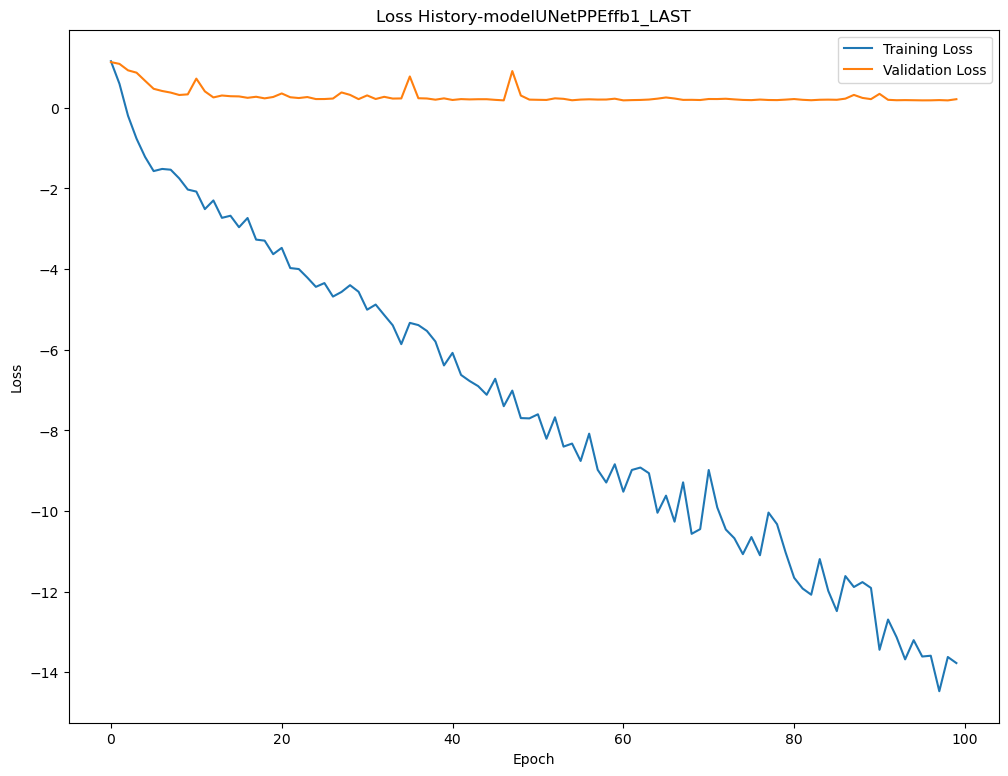

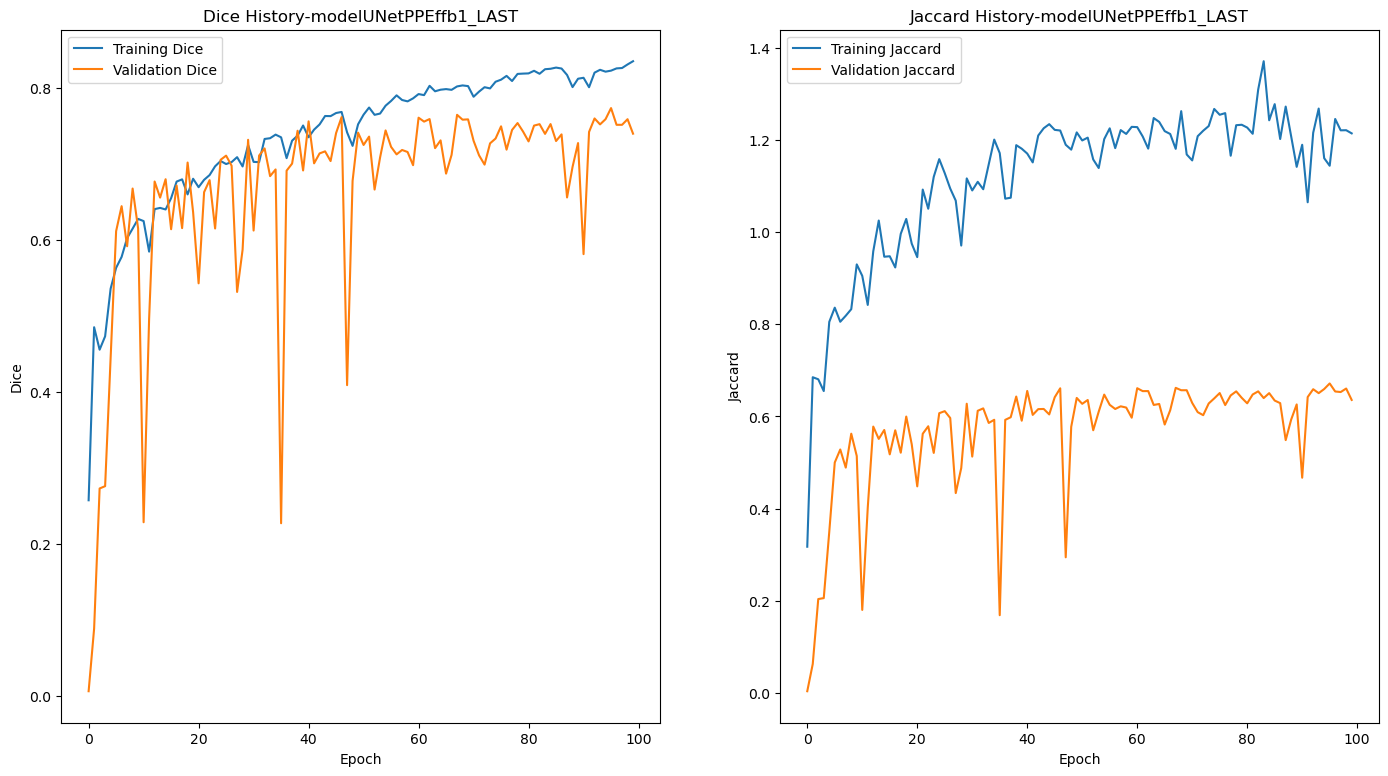

In [69]:
for fold in range(1):
    seg_model_name = 'UNetPPEffb6_LAST'
    print(f'#'*15)
    print(f'### Fold: {fold}')
    print(f'#'*15)
    run = wandb.init(project='med-segmentation-unetppb1-1', 
                     config={k:v for k, v in dict(vars(CFG)).items() if '__' not in k},
                     anonymous=anonymous,
                     name=f"fold-{fold}|dim-{CFG.img_size[0]}x{CFG.img_size[1]}|model-{CFG.model_name}",
                     group=CFG.comment,
                    )
    train_loader, valid_loader = train_loader,valid_loader
    model     =   build_model()
    optimizer = optim.AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
    scheduler =  fetch_scheduler(optimizer) 
    
    model, historys_UNET = run_training(model, optimizer, scheduler,
                                device=CFG.device,
                                num_epochs=CFG.epochs)
    # run.finish()
    # display(ipd.IFrame(run.url, width=1000, height=720))
    plt.figure(figsize=(12,9))

    plt.plot(historys_UNET['Train Loss'], label=f'Training Loss')
    plt.plot(historys_UNET['Valid Loss'], label=f'Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Loss History-model{seg_model_name}')


    plt.figure(figsize=(17,9))
    plt.subplot(1, 2, 1)
    plt.plot(historys_UNET['Train Dice'], label=f'Training Dice')
    plt.plot(historys_UNET['Valid Dice'], label=f'Validation Dice')
    plt.xlabel('Epoch')
    plt.ylabel('Dice')
    plt.legend()
    plt.title(f'Dice History-model{seg_model_name}')

    plt.subplot(1, 2, 2)
    plt.plot(historys_UNET['Train Jaccard'], label=f'Training Jaccard')
    plt.plot(historys_UNET['Valid Jaccard'], label=f'Validation Jaccard')
    plt.xlabel('Epoch')
    plt.ylabel('Jaccard')
    plt.legend()
    plt.title(f'Jaccard History-model{seg_model_name}')
    plt.show()
    torch.save(model.state_dict(), f'{seg_model_name}_std.pth')
    torch.save(model, f'{seg_model_name}.pt')

In [77]:
history = historys_UNET
print(f""" MODEL: {seg_model_name} Train DICE MAX:{max(history['Train Dice'])} IOU MAX:{max(history['Train Jaccard'])} Train Loss MIN:{min(history['Train Loss'])} 
        MODEL: {seg_model_name} VAL DICE MAX:{max(history['Valid Dice'])} VAL IOU MAX:{max(history['Valid Jaccard'])} VAL Loss MIN:{min(history['Valid Loss'])} \n """)

 MODEL: UNetPPEffb1_LAST Train DICE MAX:0.8354283571243286 IOU MAX:1.3707932233810425 Train Loss MIN:-14.468043276077395 
        MODEL: UNetPPEffb1_LAST VAL DICE MAX:0.7737004160881042 VAL IOU MAX:0.6716439127922058 VAL Loss MIN:0.18425250064802443 
 


Очистите кэш GPU перед обучением новой модели

In [79]:
gpus = GPUtil.getGPUs()
gpu = gpus[0]
GPUtil.showUtilization()
free_memory = gpu.memoryFree
torch.cuda.empty_cache()

| ID | GPU | MEM |
------------------
|  0 |  0% |  8% |


# Валидация

Очистка кэша GPU

In [151]:
gpus = GPUtil.getGPUs()
gpu = gpus[0]
GPUtil.showUtilization()
free_memory = gpu.memoryFree
torch.cuda.empty_cache()

| ID | GPU | MEM |
------------------
|  0 |  0% |  7% |


In [153]:
valid_dataset = BuildDataset(x_val, y_val, transforms=data_transforms['valid'])
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False, pin_memory=True)

Загружаем веса модели. В weight_c1 укажите название файла с весами необходимой модели. В параметрах model укажите тот encoder_name, с которым обучались веса модели.

In [156]:
weight_c1 = 'UNetPPEffb6_LAST_std.pth'
model = smp.UnetPlusPlus(
    encoder_name="efficientnet-b6", encoder_weights=None, in_channels=1, classes=1)
model.to('cuda')
model.load_state_dict(torch.load(
    weight_c1, map_location='cuda'))
model.eval()

UnetPlusPlus(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSam

In [158]:
device='cpu'

In [160]:
preds = []
for step, (images, masks) in enumerate(valid_loader):        
        images  = images.to(device, dtype=torch.float).cpu()
        masks   = masks.to(device, dtype=torch.float).cpu()
        models=model.cpu()

        for fold in range(1):
            # model = load_model(f"best_epoch-{fold:02d}.bin")
            with torch.no_grad():
                pred = models(images).cpu()
                pred = (nn.Sigmoid()(pred)>0.5).double()
                
                #preds = torch.argmax(nn.Sigmoid()(pred),axis=1).double()
                #val_dice = dice_coef(mask, pred).cpu().detach().numpy()
                #val_jaccard = iou_coef(mask, pred).cpu().detach().numpy()
                #val_scores.append([val_dice, val_jaccard])
                
                
                print( sum(sum(sum(sum(pred)))))
            preds.append(pred)
            
        images  = images.cpu().detach()
        preds = torch.mean(torch.stack(preds, dim=0), dim=0).cpu().detach()
        break

tensor(71933., dtype=torch.float64)


In [164]:
#Альтернативный расчет Dice

def dice_coef_2(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    smooth = 0.0001
    intersection = (y_true*y_pred).sum()
    print(intersection)
    print(((y_true_f).sum() + (y_pred_f).sum() + smooth))
    print((y_true_f).sum())
    print((y_pred_f).sum())
    return (2. * intersection + smooth) / ((y_true_f).sum() + (y_pred_f).sum() + smooth)

In [168]:
#Метрика Dice-Sørensen coefficient

dice_coef(masks, preds).cpu().detach().numpy()

array(0.7555287, dtype=float32)

In [170]:
#Метрика IoU (Jaccard index)

iou_coef(masks, preds).cpu().detach().numpy()

array(0.638809, dtype=float32)

In [172]:
#print(val_scores)

[]


Результаты работы модели: изображение, изображение + размеченая маска сегментации, изображение + предсказанная маска сегментации.

Здесь можно визуально оценить, насколько хорошо (или плохо) ваша модель работает.

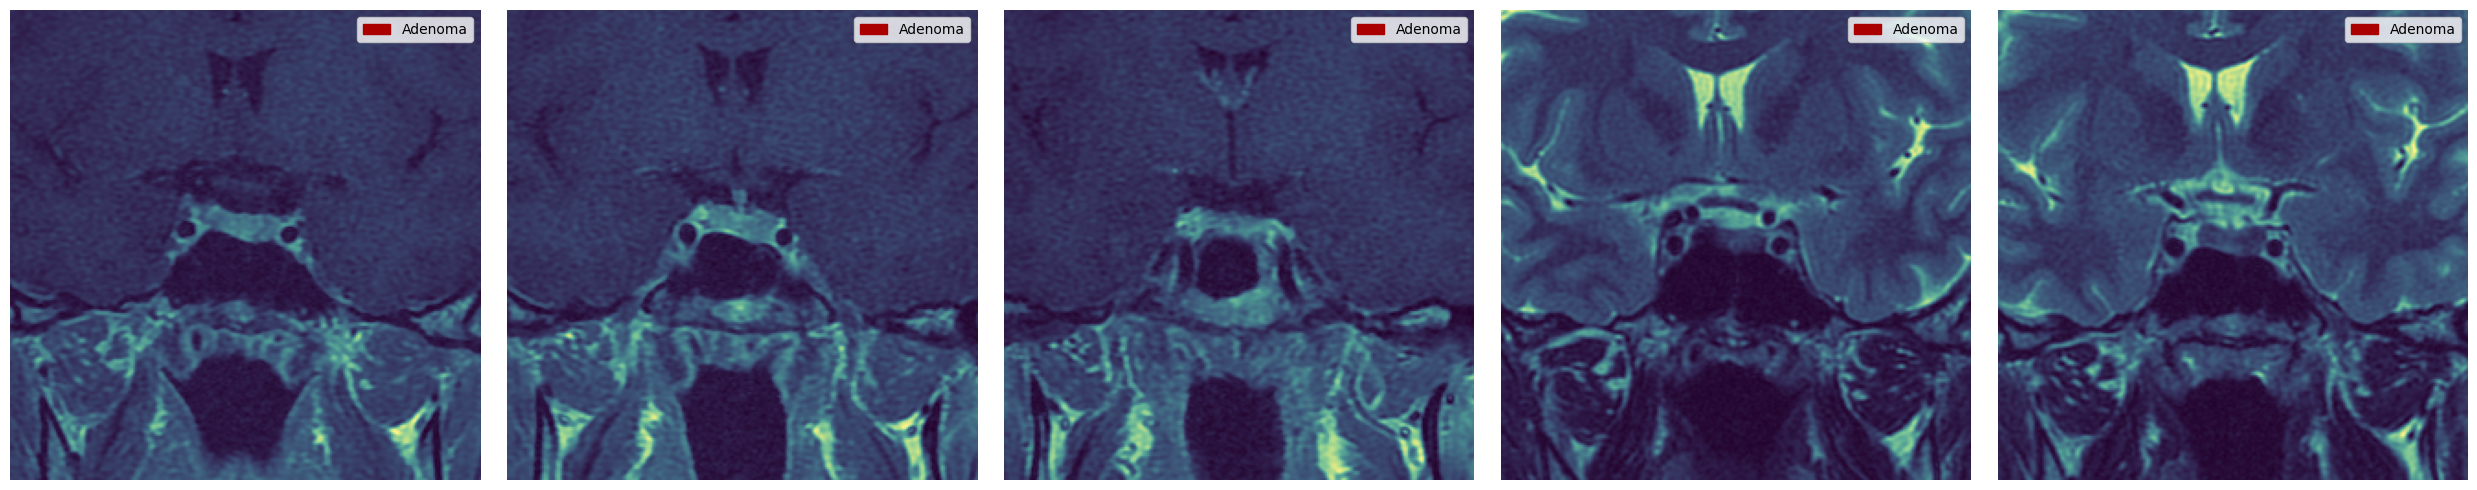

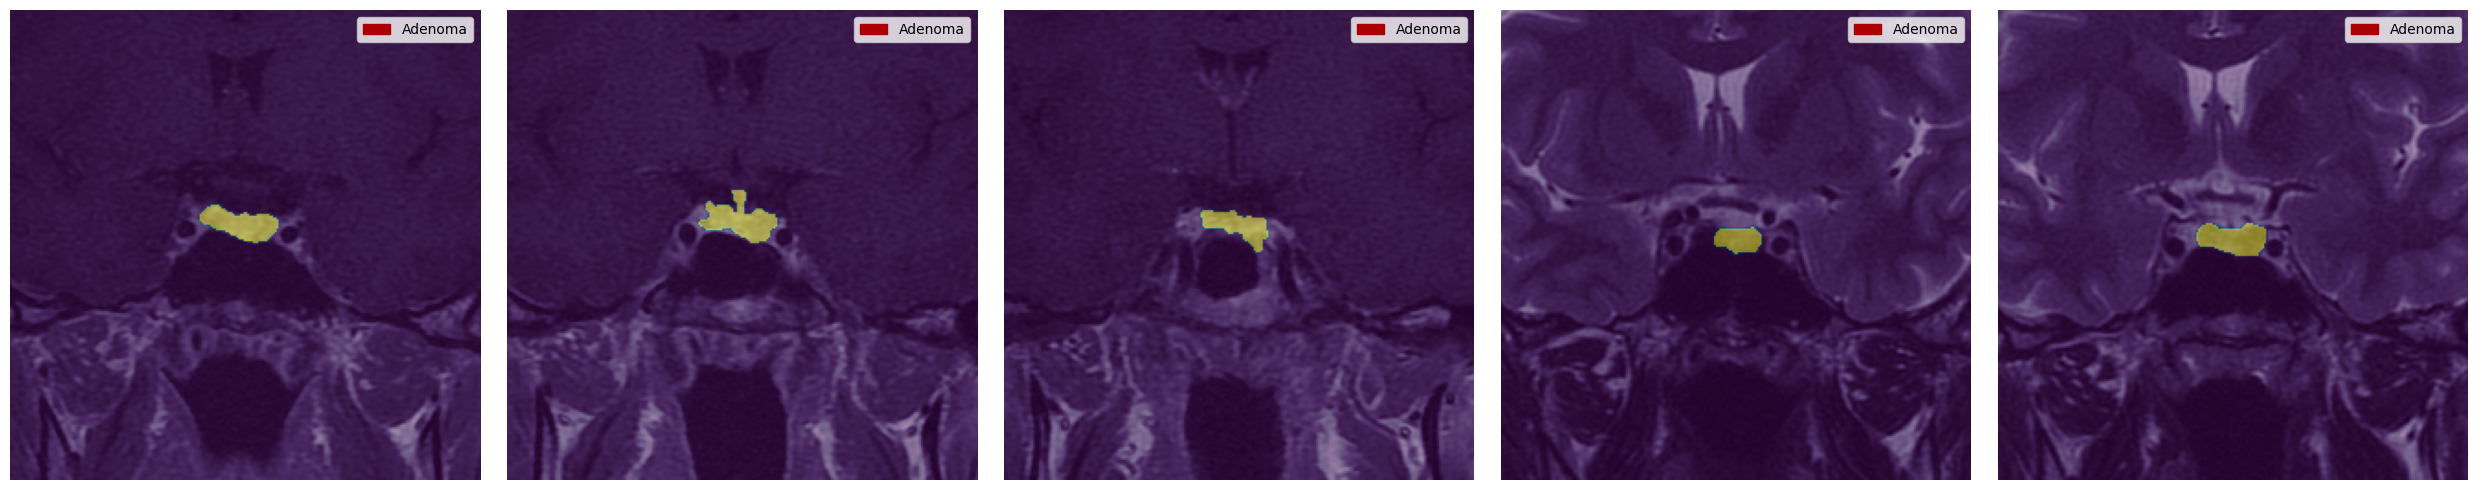

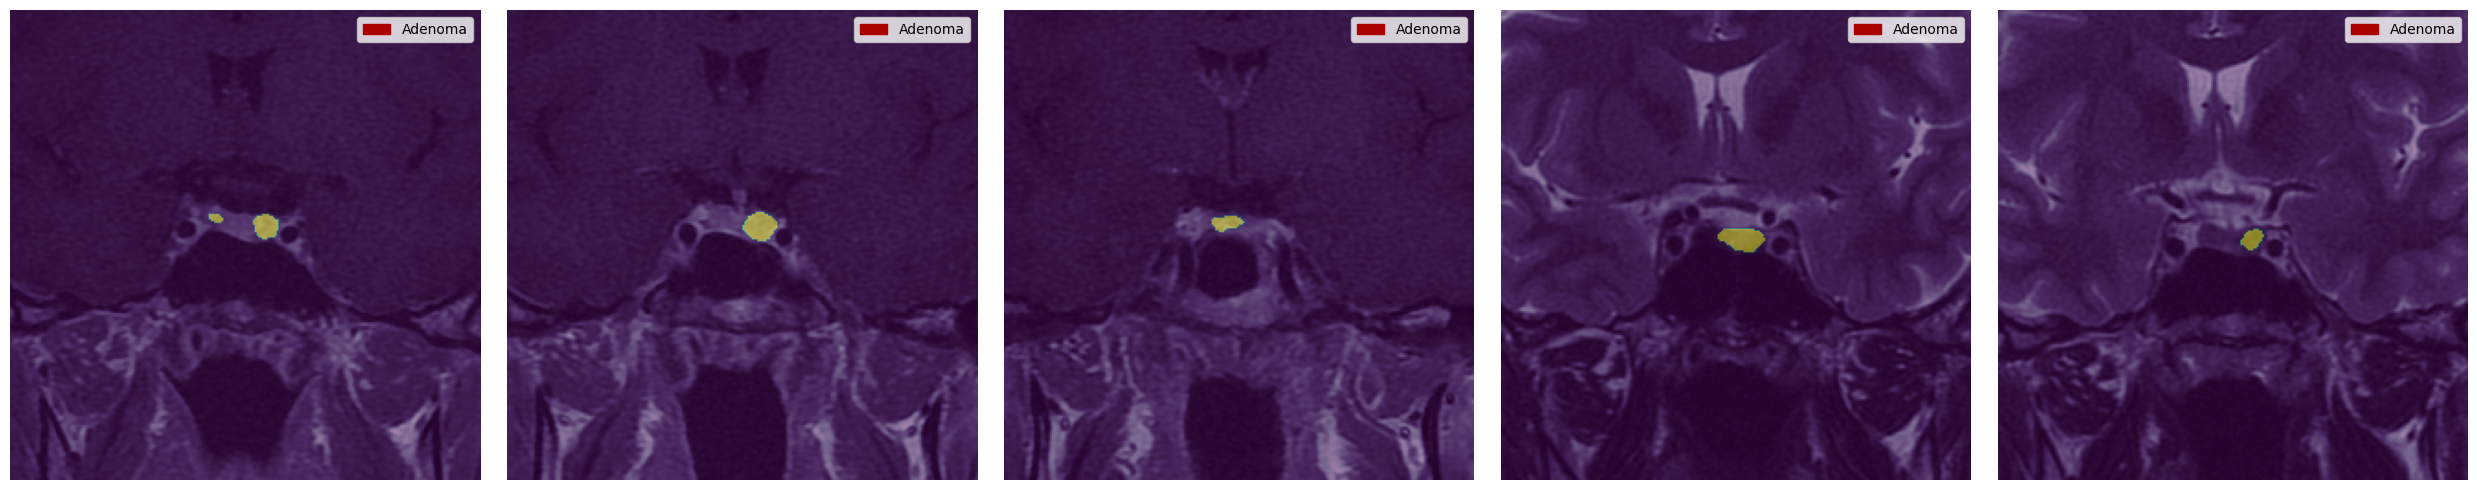

In [174]:
plot_batch(images, images, size=5)
plot_batch(images, masks, size=5)
plot_batch(images, preds, size=5)